# Hvordan hente data fra SSB? Sånn.

In [2]:
import pandas as pd
import numpy as np
import requests
from pyjstat import pyjstat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

In [3]:
def apiToDataframe(postUrl, query):

	# postUrl som spørringen skal postes mot
	# Spørringen og endepunktet til API-et kan hentes fra Statistikkbanken.

	res = requests.post(postUrl, json=query)
	# legger resultat i ds. DS har i tillegg en del metadata
	ds = pyjstat.Dataset.read(res.text)
	# skriver resultatet til to dataframes
    # først dataframe med tekst
	df = ds.write('dataframe')
    # deretter dataframe med koder
	df_id = ds.write('dataframe', naming='id')
    # returnerer også ds i tilfelle en trenger metadata
	return df, df_id, ds

In [4]:
postUrl = "https://data.ssb.no/api/v0/no/table/13760/"
apiQuery = {
  "query": [
    {
      "code": "Kjonn",
      "selection": {
        "filter": "item",
        "values": [
          "0",
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Alder",
      "selection": {
        "filter": "item",
        "values": [
          "15-74",
          "15-24",
          "25-74"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}

In [5]:
df, df_id, ds = apiToDataframe(postUrl, apiQuery)

Som du ser er kommer dataen i litt vilkårlige formater... Noen ganger må man rydde litt, men et godt utgangspunkt er infer_objects() funksjonen.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60768 entries, 0 to 60767
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   kjønn               60768 non-null  object 
 1   alder               60768 non-null  object 
 2   type justering      60768 non-null  object 
 3   statistikkvariabel  60768 non-null  object 
 4   måned               60768 non-null  object 
 5   value               56763 non-null  float64
dtypes: float64(1), object(5)
memory usage: 2.8+ MB


In [7]:
df.infer_objects().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60768 entries, 0 to 60767
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   kjønn               60768 non-null  object 
 1   alder               60768 non-null  object 
 2   type justering      60768 non-null  object 
 3   statistikkvariabel  60768 non-null  object 
 4   måned               60768 non-null  object 
 5   value               56763 non-null  float64
dtypes: float64(1), object(5)
memory usage: 2.8+ MB


Den klarte ikke konvertere måned kolonnen til DATETIME. Dette må vi gjøre manuelt.

In [8]:
df['date'] = pd.to_datetime(df['måned'], format='%YM%m')
df = df.drop('måned', axis = 1)
df

,kjønn,alder,type justering,statistikkvariabel,value,date
0,Begge kjønn,15-74 år,Trend,Arbeidsstyrken (1000 personer),2449.0,2006-01-01
1,Begge kjønn,15-74 år,Trend,Arbeidsstyrken (1000 personer),2450.0,2006-02-01
2,Begge kjønn,15-74 år,Trend,Arbeidsstyrken (1000 personer),2452.0,2006-03-01
3,Begge kjønn,15-74 år,Trend,Arbeidsstyrken (1000 personer),2455.0,2006-04-01
4,Begge kjønn,15-74 år,Trend,Arbeidsstyrken (1000 personer),2459.0,2006-05-01
...,...,...,...,...,...,...
60763,Kvinner,25-74 år,Ikke sesongjustert,Befolkningen (1000 personer),1695.0,2023-03-01
60764,Kvinner,25-74 år,Ikke sesongjustert,Befolkningen (1000 personer),1696.0,2023-04-01
60765,Kvinner,25-74 år,Ikke sesongjustert,Befolkningen (1000 personer),1697.0,2023-05-01
60766,Kvinner,25-74 år,Ikke sesongjustert,Befolkningen (1000 personer),1698.0,2023-06-01


Mye bedre!

In [9]:
df_id

,Kjonn,Alder,Justering,ContentsCode,Tid,value
0,0,15-74,T,Arbeidsstyrken,2006M01,2449.0
1,0,15-74,T,Arbeidsstyrken,2006M02,2450.0
2,0,15-74,T,Arbeidsstyrken,2006M03,2452.0
3,0,15-74,T,Arbeidsstyrken,2006M04,2455.0
4,0,15-74,T,Arbeidsstyrken,2006M05,2459.0
...,...,...,...,...,...,...
60763,2,25-74,IS,Befolkningen,2023M03,1695.0
60764,2,25-74,IS,Befolkningen,2023M04,1696.0
60765,2,25-74,IS,Befolkningen,2023M05,1697.0
60766,2,25-74,IS,Befolkningen,2023M06,1698.0


df_id er bare en ryddigere versjon av den samme dataen.

In [10]:
ds

Dataset([('class', 'dataset'),
         ('label',
          '13760: Arbeidsstyrken, sysselsatte, arbeidsledige  og utførte ukeverk for personer 15-74 år, etter kjønn, alder, type justering, statistikkvariabel og måned'),
         ('source', 'Statistisk sentralbyrå'),
         ('updated', '2023-08-24T06:00:00Z'),
         ('id', ['Kjonn', 'Alder', 'Justering', 'ContentsCode', 'Tid']),
         ('size', [3, 3, 4, 8, 211]),
         ('dimension',
          OrderedDict([('Kjonn',
                        OrderedDict([('extension',
                                      OrderedDict([('show', 'value')])),
                                     ('label', 'kjønn'),
                                     ('category',
                                      OrderedDict([('index',
                                                    OrderedDict([('0', 0),
                                                                 ('1', 1),
                                                                 ('2', 2)])),

ds kan man som regel ignorere.

# CASE: Empirisk Phillips-kurve

La oss ta et praktisk eksempel. Phillipskurven er kjent som sammenhengen mellom inflasjon og arbeidsledighet. Lav arbeidsledighet betyr høy inflasjon og vice versa. Sammenhengen vises ofte grafisk som en kovekst avtakende kurve. La oss se hvordan den faktisk ser ut i Norge.

In [11]:
# KPI
df1, df_id, ds = apiToDataframe('https://data.ssb.no/api/v0/no/table/03013/', {
  "query": [
    {
      "code": "Konsumgrp",
      "selection": {
        "filter": "vs:CoiCop2016niva1",
        "values": []
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "KpiIndMnd"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
})
df1['date'] = pd.to_datetime(df1['måned'], format='%YM%m')
#df1['value'] = df1['value']/df1['value'].shift(12) - 1 # yoy
df1 = df1[['value', 'date']]
df1 = df1.rename(columns={'value':'kpi'})

Henter konumpirsindeksen.

In [12]:
# ledightesrate
df2, df_id, ds = apiToDataframe('https://data.ssb.no/api/v0/no/table/13760/', {
  "query": [
    {
      "code": "Kjonn",
      "selection": {
        "filter": "item",
        "values": [
          "0"
        ]
      }
    },
    {
      "code": "Justering",
      "selection": {
        "filter": "item",
        "values": [
          "IS"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "ArbledProsArbstyrk"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
})
df2['date'] = pd.to_datetime(df2['måned'], format='%YM%m')
df2 = df2[['value', 'date']]
df2['value'] = df2['value']/100
df2 = df2.rename(columns={'value':'ledighet'})

Henter arbeidsledighetsraten.

In [13]:
df = pd.merge(df1,df2, on='date').set_index('date').dropna()
df

,kpi,ledighet
date,,
2006-01-01,82.7,0.042
2006-02-01,83.4,0.043
2006-03-01,83.6,0.040
2006-04-01,84.3,0.040
2006-05-01,84.3,0.041
...,...,...
2023-03-01,127.6,0.038
2023-04-01,129.0,0.035
2023-05-01,129.6,0.032


Slår sammen tabellene.

In [1]:
sns.violinplot(dfs)

NameError: name 'sns' is not defined

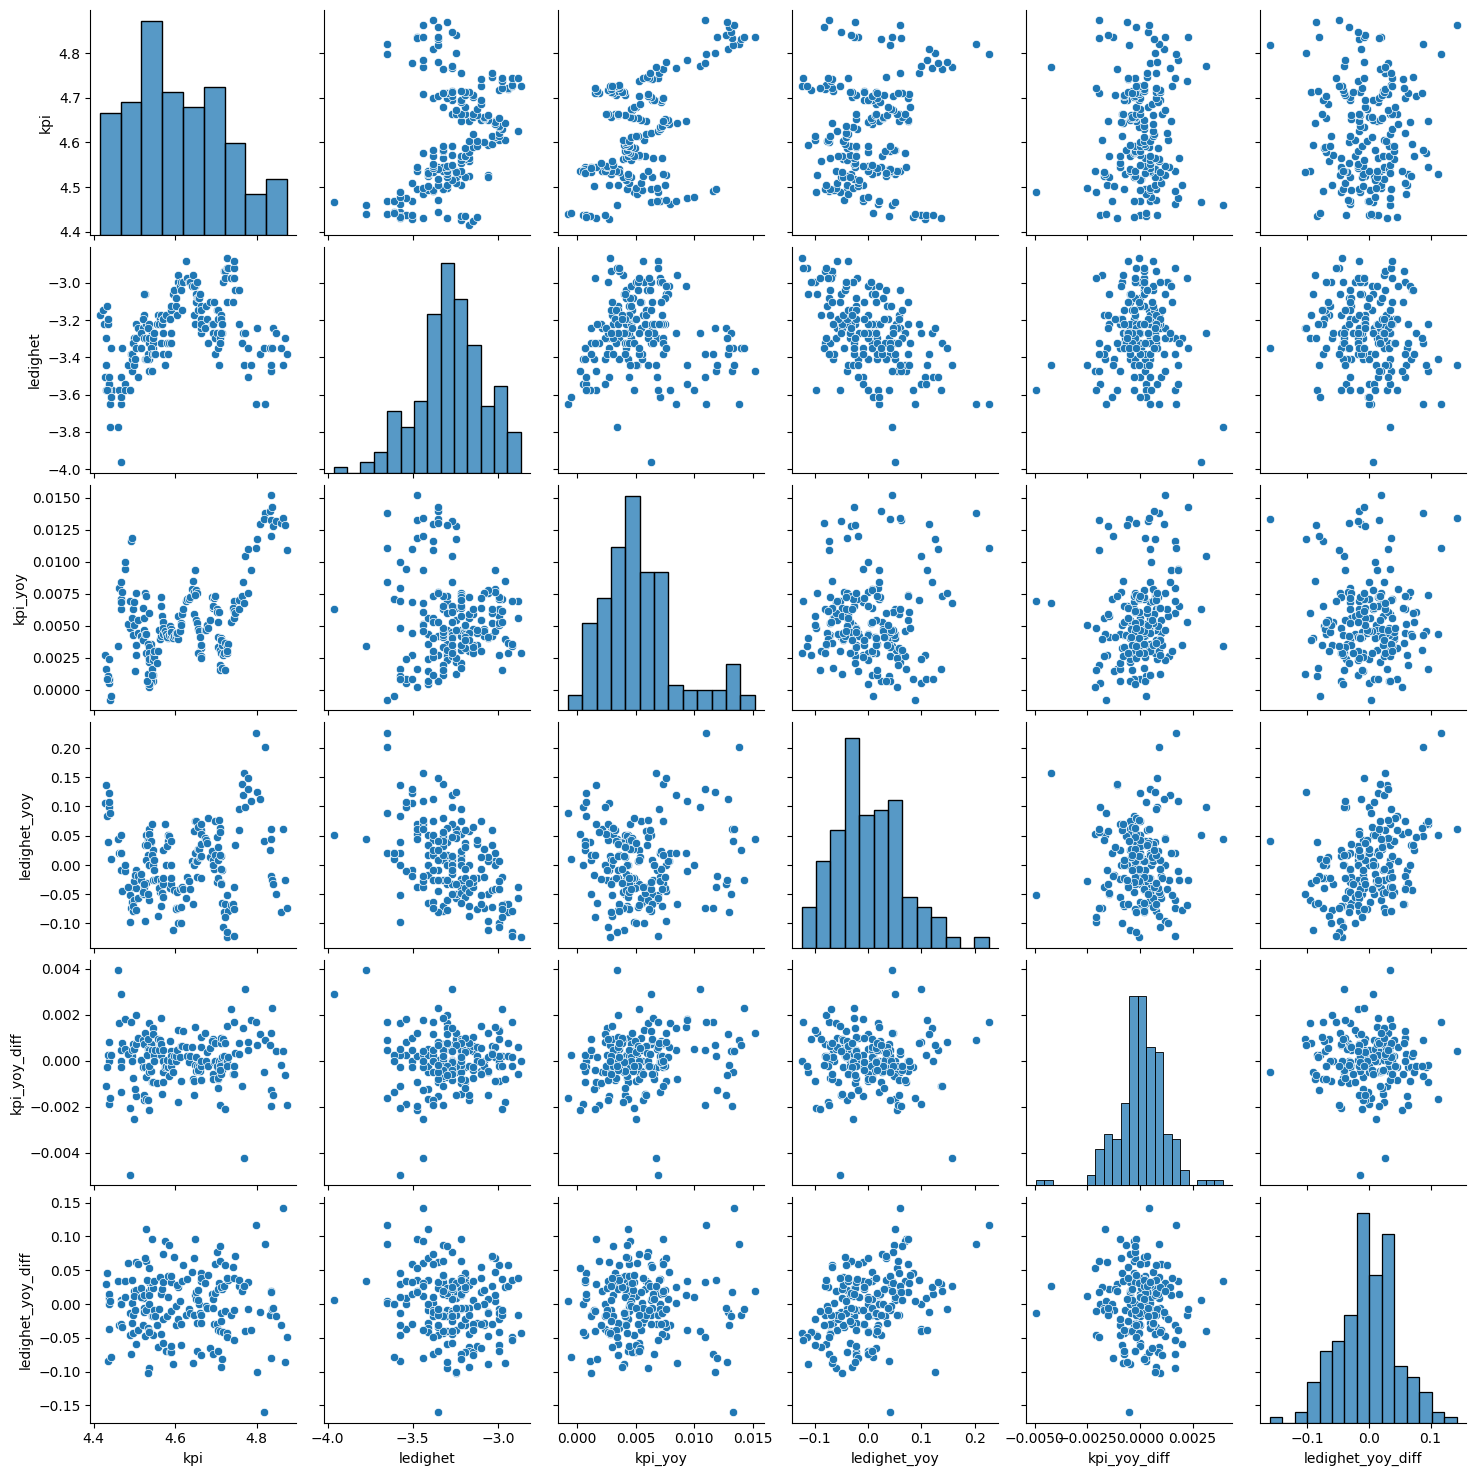

In [14]:
dfs = df.transform(lambda x: np.log(x))

dfs['kpi_yoy'] = dfs['kpi']/dfs['kpi'].shift(12) - 1
dfs['ledighet_yoy'] = dfs['ledighet']/dfs['ledighet'].shift(12) - 1

dfs['kpi_yoy_diff'] = dfs['kpi_yoy'].diff()
dfs['ledighet_yoy_diff'] = dfs['ledighet_yoy'].diff()

sns.pairplot(dfs)
plt.show()

Her studerer vi forskjellige trasnformasjoner av dataen for de to variablene. en god tommelregel er at man vil velge variabler som er normalfordelt (eller i det minste symmetrisk fordelt) og hvor forholdet mellom interressevariablene er visuelt tydelige. Hvis vi ikke klarer å finne en sammenhengen visuelt klarer ikke OLS det heller. Etter å ha testet litt rundt velger jeg å gå videre med endringen i yoy raten. Siden alle sammenhengene var ganske utydelige gikk jeg for dem fordi forelingen var finest.

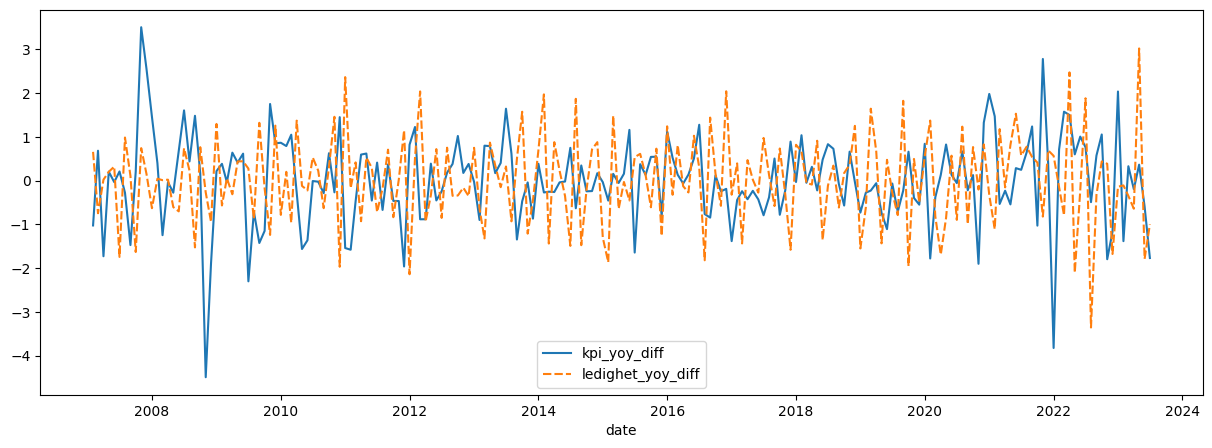

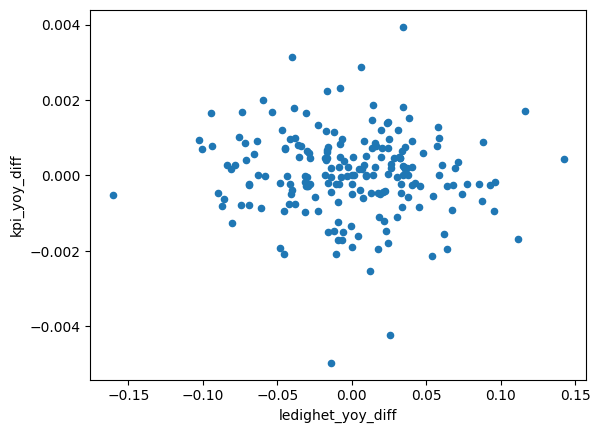

In [15]:
scalers = StandardScaler()
colss = dfs.columns

scaled_dfs = pd.DataFrame(scalers.fit_transform(dfs), columns=colss, index=df.index)

plt.figure(figsize=(15,5))
sns.lineplot(scaled_dfs[['kpi_yoy_diff', 'ledighet_yoy_diff']])
plt.show()

dfs.plot(x='ledighet_yoy_diff', y= 'kpi_yoy_diff', kind='scatter')
plt.show()

Kan ense i TS plotten en negativ korrelasjon, men den må i tilfellet være svak. I scatteren er den mer eller midre usynlig.

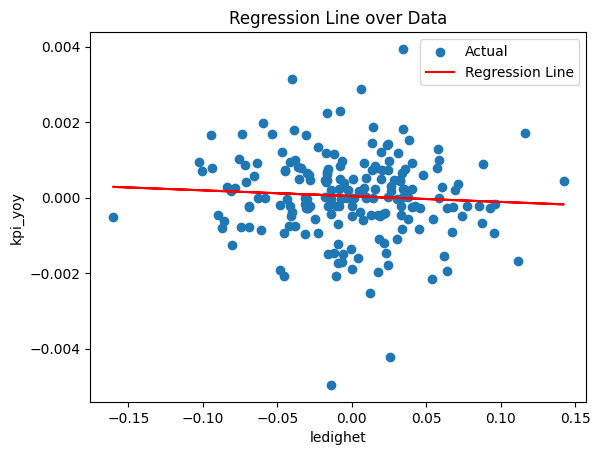

[3.98919238e-05] [[-0.00153292]] 0.004277867485504738


In [16]:
from sklearn.linear_model import LinearRegression
df_reg=dfs.dropna()

#poly = PolynomialFeatures(degree=2) # PK-kurven tegnes ofte som et annen grads polynom
model1 = LinearRegression()
X, y = df_reg['ledighet_yoy_diff'].to_frame(), df_reg['kpi_yoy_diff'].to_frame()

model1.fit(X,y)

# Make predictions
y_pred = model1.predict(X)

# Create plot
plt.scatter(df_reg['ledighet_yoy_diff'].to_frame(), y, label='Actual')
plt.plot(df_reg['ledighet_yoy_diff'].to_frame(), y_pred, color='red', label='Regression Line')

plt.title('Regression Line over Data')
plt.xlabel('ledighet')
plt.ylabel('kpi_yoy')
plt.legend()

plt.show()

print(model1.intercept_, model1.coef_, model1.score(X, y))

Vi Kjører en linæreregression mellom de to variablene for å se om det er noe forhold mellom dem.

Hva synes du om denne resultatet? Er dette Phillipskurven vi leter etter?

## Kikker på lags

Forhåpentligvis var du ikke fornøyd med resultatene jeg presenterte. Så la oss gå litt bedre til verks.

In [17]:
def create_lag(df, num=1):
    new_df = df.copy()
    for i in range(1,num +1):
        lag_df = df.shift(i)
        lag_df.columns = [f"{col}_lag{i}" for col in df.columns]
        new_df = pd.concat([new_df, lag_df], axis=1)
    return new_df
    
# df_lag = create_lag(dfs['ledighet_yoy_diff'].to_frame(),7)

df_lag = dfs['ledighet_yoy_diff'].to_frame() # seems to be the significant ones
df_lag['ledighet_yoy_diff_l1'] = df_lag['ledighet_yoy_diff'].shift(1)
df_lag['ledighet_yoy_diff_l6'] = df_lag['ledighet_yoy_diff'].shift(6)

df_reg = pd.concat([dfs['kpi_yoy_diff'],df_lag], axis=1).dropna()
X, y = df_reg.drop('kpi_yoy_diff', axis=1).to_numpy(), df_reg['kpi_yoy_diff'].to_numpy().reshape(-1,1)

model2 = LinearRegression()
model2.fit(X,y)


print(model2.intercept_, model2.coef_, model2.score(X, y))

# Get the number of samples and number of predictors
n_samples, n_features = X.shape

# Get the coefficients and intercept
beta_0 = model2.intercept_
betas = model2.coef_

# Calculate the residuals
y_pred = model2.predict(X)
residuals = y - y_pred

# Calculate the standard error of the residuals
stderr_residuals = np.std(residuals)

# Calculate the standard error for each coefficient
X_with_const = np.column_stack([np.ones((n_samples, 1)), X])
stderr_betas = np.sqrt(np.linalg.inv(X_with_const.T @ X_with_const).diagonal()) * stderr_residuals

# Calculate the t-statistics
t_betas = betas / stderr_betas[1:]
t_intercept = beta_0 / stderr_betas[0]

# Calculate degrees of freedom
f = n_samples - n_features - 1

# Calculate p-values
p_values_betas = 2 * (1 - stats.t.cdf(np.abs(t_betas), f))
p_value_intercept = 2 * (1 - stats.t.cdf(np.abs(t_intercept), f))

# print("T-statistic for intercept:", t_intercept)
print("T-statistics for betas:", t_betas)
# print("P-value for intercept:", p_value_intercept)
print("P-values for betas:", p_values_betas)

[4.89413559e-05] [[-0.0032796  -0.00374669  0.00374973]] 0.05529415905036417
T-statistics for betas: [[-1.82650351 -2.08138783  2.19396609]]
P-values for betas: [[0.06936048 0.03875304 0.02946392]]


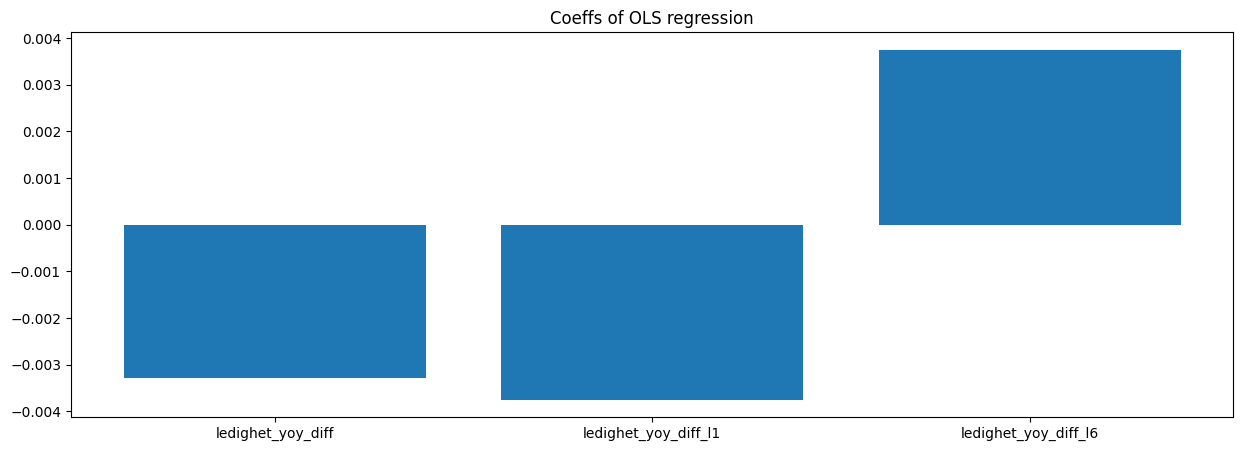

In [18]:
plt.figure(figsize=(15,5))
plt.bar(df_reg.drop('kpi_yoy_diff', axis=1).columns ,model2.coef_[0])
plt.title('Coeffs of OLS regression')
plt.show()

Vi har funnet ut at sammenhengen mellom arbeidsledighet og inflasjon har lagged sammenhenger. Lav arbeidsledighet i en måned korrelerer med høy inflasjon i neste måned, og lav arbeidsledigheht et halvt år i forveien korrellerer med med lav inflasjon i dag. 

Hvordan forklarer vi dette økonomisk? Dersom nullhypotesen stemmer (at arbeidsledighet har en negativ kausal effekt på inflasjon) kan man forklare den første laggen ved at det tar ca. en måned for at effekten avbeidsledigheten slår ut i inflajon. Altså flere kommer i arbeid og jobber en måned til å får første lønning (el.) og så konsumerer mer, som igjen øker inflasjon.

Men hvordan forklarer vi da den positive sammenhengen med et halvårs mellomrom? hvis vi godtar den første laggen som et gyldig resultat, må vi nesten også ta den sjette. T-scoren er tross alt mer ekstrem. Godt spørsmål. Her kan man bare komme med teorier uten å gjøre ytterligere undersøkelser. En teori er at det er halvårlige sykluser i arbeidsmarkedet, og derfor også inflasjonen.

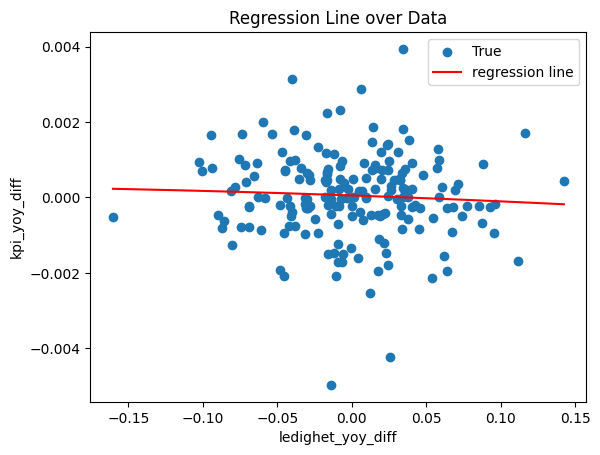

In [19]:
# Make predictions
y_pred = model2.predict(X)

# Create plot
plt.scatter(df_reg['ledighet_yoy_diff'].to_frame(), y, label='True')
# plt.scatter(df_reg['ledighet_yoy_diff'].to_frame(), y_pred, color='red', label='Predicted',)

# Find line of best fit
a, b, c = np.polyfit(df_reg['ledighet_yoy_diff'], y_pred, deg=2)

# Generate points along the curve of best fit for plotting
x_vals = np.linspace(df_reg['ledighet_yoy_diff'].min(), df_reg['ledighet_yoy_diff'].max(), 400)
y_vals = a * x_vals**2 + b * x_vals + c

# Add line of best fit to plot
plt.plot(x_vals, y_vals, color='red', label='regression line')

plt.title('Regression Line over Data')
plt.xlabel('ledighet_yoy_diff')
plt.ylabel('kpi_yoy_diff')
plt.legend()
plt.show()

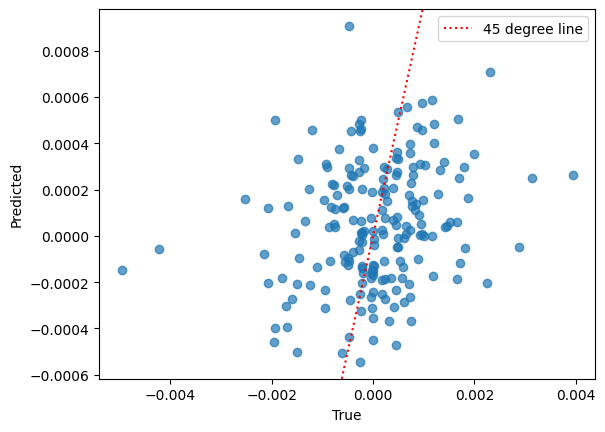

In [20]:
plt.scatter(y, y_pred, alpha=0.7)
plt.axline([0, 0], [0.00001, 0.00001], color='red', linestyle=':', label='45 degree line')
plt.legend()
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

Her synes det spesielt godt at modellen vår har dårlig forklaringskraft. Ved 100% forklaringskraft vil alle prikkene ligge på den rød linjen.

I den siste modellen slå vi altspå fast at ca 5% av variasjonen i endringen i den årlig inlasjonsraten kan forklares med endrinen i årlig endring i arbedsledighetsraten. Sammenhengen er svak (bettaene e små) og muligens ikke eksisterende (ikke særlig ekstreme t-scores). Likevel tyder dataen på at det er en svak negativ korrelasjon mellom arbeidsledighet og inflajson på kort sikt.

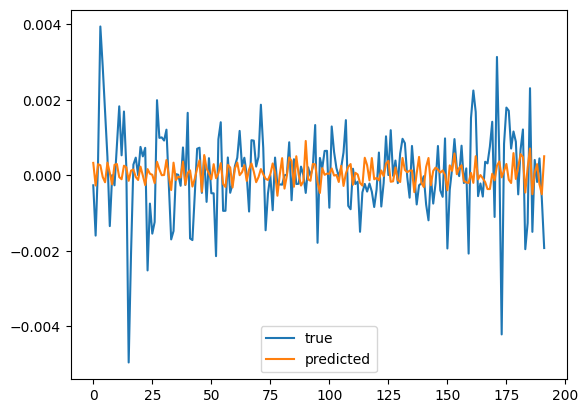

In [23]:
plt.plot(y, label='true')
plt.plot(y_pred, label='predicted')
plt.legend()
plt.show()